In [13]:
#import sys
#!{sys.executable} -m pip install pyLDAvis

import pandas as pd
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import re
import pyLDAvis.gensim

from gensim.models import Phrases
from gensim import corpora
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from langdetect import detect
from tqdm import tqdm_notebook
from gensim import models
from itertools import chain
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

%matplotlib inline
import seaborn as sns

tqdm_notebook().pandas()

In [14]:
from lib import data, cluster, Timer
max_lines = None
filename = 'all-201901'

keyword_data = data.extract_keywords(filename + '.pkl', max_lines)
data = pd.DataFrame(keyword_data).fillna(0)

In [15]:
data.shape

(7000, 3)

In [16]:
data = data.drop(['Unnamed: 0'], axis=1)

In [17]:
data.head()

testlog  \
0  ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1  BackupRestoreRestrictColorSettingsNoConfigChan...   
2  BackupRestoreEwsConfigThirdPartyApplicationNon...   
3  SharePointLongScanDuplexXps.Aggregate.20181211...   
4                         DoorOpen.1.20181216-070155   

                                        sysmain_logs  
0  ctor mfp diagnostics install handlerequest net...  
1  remoteimagestoreservice solution notifypermiss...  
2  remoteimagestoreservice synclicense enginesecu...  
3  formattertorissformatterside sharepointaccess ...  
4  stringid remoteimagestoreservice synclicense e...

In [18]:
data = data.dropna().reset_index(drop=True)

In [19]:
data.shape

(6663, 2)

In [20]:
test = data
test.head()

testlog  \
0  ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1  BackupRestoreRestrictColorSettingsNoConfigChan...   
2  BackupRestoreEwsConfigThirdPartyApplicationNon...   
3  SharePointLongScanDuplexXps.Aggregate.20181211...   
4                         DoorOpen.1.20181216-070155   

                                        sysmain_logs  
0  ctor mfp diagnostics install handlerequest net...  
1  remoteimagestoreservice solution notifypermiss...  
2  remoteimagestoreservice synclicense enginesecu...  
3  formattertorissformatterside sharepointaccess ...  
4  stringid remoteimagestoreservice synclicense e...

In [21]:
data.shape

(6663, 2)

In [22]:
data.iloc[0,1]

'ctor mfp diagnostics install handlerequest net solution endread asyncrequest networkstream idcertdetails ring error sockets doworki installation receivenocheck test socket workerthread threading traplistener fi invokecallback services snmp workitem current getcertificatedetailsbyusage children error subsystem lazyasyncresult logging timer listener hp endfirstread dorequest session pmltosnmp receiveasyncrequest traphelper cavsinstrumentation get internalsetnetworkcertificate pfxidentitycertificates pfxcertificatesinternal eventid threadpool starttraplistener common compactstream system httpcontext httpmodule certificate fim cavs dowork compactwebserver asn1node security snmprequest 0x990c03'

In [23]:
data['sentences'] = data.sysmain_logs.progress_map(sent_tokenize)
data['sentences'].head(1).tolist()[0][:3]

['ctor mfp diagnostics install handlerequest net solution endread asyncrequest networkstream idcertdetails ring error sockets doworki installation receivenocheck test socket workerthread threading traplistener fi invokecallback services snmp workitem current getcertificatedetailsbyusage children error subsystem lazyasyncresult logging timer listener hp endfirstread dorequest session pmltosnmp receiveasyncrequest traphelper cavsinstrumentation get internalsetnetworkcertificate pfxidentitycertificates pfxcertificatesinternal eventid threadpool starttraplistener common compactstream system httpcontext httpmodule certificate fim cavs dowork compactwebserver asn1node security snmprequest 0x990c03']

In [24]:
data.iloc[0,1]

'ctor mfp diagnostics install handlerequest net solution endread asyncrequest networkstream idcertdetails ring error sockets doworki installation receivenocheck test socket workerthread threading traplistener fi invokecallback services snmp workitem current getcertificatedetailsbyusage children error subsystem lazyasyncresult logging timer listener hp endfirstread dorequest session pmltosnmp receiveasyncrequest traphelper cavsinstrumentation get internalsetnetworkcertificate pfxidentitycertificates pfxcertificatesinternal eventid threadpool starttraplistener common compactstream system httpcontext httpmodule certificate fim cavs dowork compactwebserver asn1node security snmprequest 0x990c03'

In [25]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])


[['ctor', 'mfp', 'diagnostics', 'install', 'handlerequest', 'net', 'solution', 'endread', 'asyncrequest', 'networkstream', 'idcertdetails', 'ring', 'error', 'sockets', 'doworki', 'installation', 'receivenocheck', 'test', 'socket', 'workerthread', 'threading', 'traplistener', 'fi', 'invokecallback', 'services', 'snmp', 'workitem', 'current', 'getcertificatedetailsbyusage', 'children', 'error', 'subsystem', 'lazyasyncresult', 'logging', 'timer', 'listener', 'hp', 'endfirstread', 'dorequest', 'session', 'pmltosnmp', 'receiveasyncrequest', 'traphelper', 'cavsinstrumentation', 'get', 'internalsetnetworkcertificate', 'pfxidentitycertificates', 'pfxcertificatesinternal', 'eventid', 'threadpool', 'starttraplistener', 'common', 'compactstream', 'system', 'httpcontext', 'httpmodule', 'certificate', 'fim', 'cavs', 'dowork', 'compactwebserver', 'asn1node', 'security', 'snmprequest', '0x990c03']]


In [26]:
data['tokens'] = data['tokens_sentences'].map(lambda sentences: list(chain.from_iterable(sentences)))

In [27]:
data.head()

testlog  \
0  ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1  BackupRestoreRestrictColorSettingsNoConfigChan...   
2  BackupRestoreEwsConfigThirdPartyApplicationNon...   
3  SharePointLongScanDuplexXps.Aggregate.20181211...   
4                         DoorOpen.1.20181216-070155   

                                        sysmain_logs  \
0  ctor mfp diagnostics install handlerequest net...   
1  remoteimagestoreservice solution notifypermiss...   
2  remoteimagestoreservice synclicense enginesecu...   
3  formattertorissformatterside sharepointaccess ...   
4  stringid remoteimagestoreservice synclicense e...   

                                           sentences  \
0  [ctor mfp diagnostics install handlerequest ne...   
1  [remoteimagestoreservice solution notifypermis...   
2  [remoteimagestoreservice synclicense enginesec...   
3  [formattertorissformatterside sharepointaccess...   
4  [stringid remoteimagestoreservice synclicense ...   

                                    tokens_sentences  \
0  [[ctor, mfp, diagnostics, install, handlereque...   
1  [[remoteimagestoreservice, solution, notifyper...   
2  [[remoteimagestoreservice, synclicense, engine...   
3  [[formattertorissformatterside, sharepointacce...   
4  [[stringid, remoteimagestoreservice, synclicen...   

                                              tokens  
0  [ctor, mfp, diagnostics, install, handlereques...  
1  [remoteimagestoreservice, solution, notifyperm...  
2  [remoteimagestoreservice, synclicense, engines...  
3  [formattertorissformatterside, sharepointacces...  
4  [stringid, remoteimagestoreservice, synclicens...

In [28]:
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [29]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=1)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [30]:
np.random.seed(123456)
num_topics = 600
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.001]*num_topics, \
                                  eta=[0.001]*len(dictionary_LDA.keys()))

CPU times: user 8min 23s, sys: 15min 58s, total: 24min 21s
Wall time: 1min 38s


In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary = dictionary_LDA, mds='mmds')
vis

/home/shyamal/HP/HP_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.162967  0.494856       1        1  3.571246
537   -0.091482  0.555370       2        1  2.530120
402    0.354303  0.444306       3        1  2.451613
509   -0.028311  0.563963       4        1  2.420912
437    0.029152  0.411119       5        1  2.215942
492   -0.230245  0.460723       6        1  2.067777
429   -0.128177  0.489795       7        1  1.940579
33     0.114045  0.408287       8        1  1.740296
11    -0.091189  0.486153       9        1  1.597677
263   -0.232179  0.457942      10        1  1.573776
166   -0.190819  0.469741      11        1  1.473094
190    0.373937  0.404261      12        1  1.411164
74     0.163814  0.420944      13        1  1.371643
552   -0.179790  0.432023      14        1  1.369815
337   -0.052719  0.536457      15        1  1.295676
587    0.089049  0.466432      16        1  1.231621
236    0.135877  0.407740      17        1  1.230091
454   -0.415704  0.401745      18        1  1.171428
10     0.352051  0.395361      19        1  1.117799
161   -0.111128  0.545800      20        1  1.092731
331    0.089895  0.453950      21        1  1.051199
387    0.160240  0.486098      22        1  1.039701
376   -0.187490  0.429056      23        1  1.038377
443   -0.097180  0.479272      24        1  0.989376
273    0.122311  0.429105      25        1  0.984778
408    0.005014  0.315056      26        1  0.981713
2      0.038509  0.348516      27        1  0.976800
341    0.131756  0.430899      28        1  0.974757
325   -0.328416  0.414217      29        1  0.973381
413    0.049645  0.411945      30        1  0.970163
...         ...       ...     ...      ...       ...
364   -0.022831 -0.193779     571        1  0.002262
365   -0.023011 -0.197685     572        1  0.002262
368   -0.022315 -0.187802     573        1  0.002262
370   -0.021765 -0.187727     574        1  0.002262
371   -0.022858 -0.193664     575        1  0.002262
372   -0.022991 -0.197464     576        1  0.002262
578   -0.023015 -0.197775     577        1  0.002262
329   -0.022612 -0.195403     578        1  0.002262
282   -0.022728 -0.193028     579        1  0.002262
327   -0.023070 -0.197934     580        1  0.002262
284   -0.023111 -0.198451     581        1  0.002262
286   -0.023022 -0.197598     582        1  0.002262
294   -0.022653 -0.195264     583        1  0.002262
295   -0.023109 -0.198442     584        1  0.002262
298   -0.022008 -0.189463     585        1  0.002262
300   -0.022817 -0.193670     586        1  0.002262
303   -0.023097 -0.198308     587        1  0.002262
306   -0.023109 -0.198436     588        1  0.002262
307   -0.022773 -0.189590     589        1  0.002262
309   -0.023107 -0.198382     590        1  0.002262
310   -0.023111 -0.198451     591        1  0.002262
313   -0.023004 -0.197122     592        1  0.002262
316   -0.023099 -0.198376     593        1  0.002262
320   -0.022846 -0.196502     594        1  0.002262
321   -0.022540 -0.195723     595        1  0.002262
322   -0.022954 -0.197136     596        1  0.002262
323   -0.023111 -0.198451     597        1  0.002262
579   -0.022976 -0.197484     598        1  0.002262
326   -0.022946 -0.197082     599        1  0.002262
599   -0.023028 -0.197899     600        1  0.002262

[600 rows x 5 columns], topic_info=     Category         Freq                                     Term  \
54    Default  3200.000000                                      app   
3     Default  2900.000000                              certificate   
30    Default  2866.000000                  pfxcertificatesinternal   
24    Default  2866.000000            internalsetnetworkcertificate   
16    Default  2839.000000                                      get   
38    Default  2342.000000                              snmprequest   
46    Default  2342.000000                               traphelper   
47    Default  2342.000000

In [33]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.013*"ldap" + 0.008*"httpmodule_certificatemanager_getmessages" + 0.008*"securefileerase" + 0.008*"openmodemport" + 0.008*"analogfaxio" + 0.008*"oxpd_constraintengine_backupworker" + 0.007*"controls" + 0.007*"modem_controlpanelwebsocketservice_renderview" + 0.007*"getxmlsettings" + 0.007*"securityservices" + 0.007*"runexport_astreference" + 0.007*"queryautocompleteresults_searchldaprecords_ticketrestresourcemanager_exportcsvdowork" + 0.007*"dictionary_createldapagent" + 0.007*"imposterlist_performnotifyregistrychange_startbackup_renamed" + 0.007*"smartcardmanager_isjetdirectsslpresent" + 0.007*"executenextstep_displayclass1_legacycontrollerrequestmanager" + 0.007*"signincontroller_0x330202" + 0.007*"0x109940_storagemanager" + 0.007*"index" + 0.007*"modemfirmwareinstaller"

1: 0.225*"statusdesc" + 0.220*"statuscode" + 0.163*"ipfax_scard" + 0.113*"dopageprintstateactivities" + 0.077*"scardlistreaders" + 0.062*"readers" + 0.004*"uri" + 0.004*"getrequeststream" + 0.004*"finishgetreques

In [34]:
lda_model[corpus[0]]

[(263, 0.7904737), (509, 0.19764817)]

In [36]:
document = data.iloc[170,1]
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=4)
pd.DataFrame([(el[0], round(el[1],2), re.findall('"([^"]*)"', topics[el[0]][1])) for el in lda_model[dictionary_LDA.doc2bow(tokens)]],
             columns=['label', 'weight', 'words in topic'])

label  weight                                     words in topic
0      37    0.02  [processoutgoingresponse, 6, processgetrespons...
1      65    0.13  [formattertorissformatterside, remoteimagestor...
2     234    0.02  [displayclass2, attemptauthenticate, dowork, f...
3     264    0.02  [mapapplicationnamefromenum, applicationnamema...
4     266    0.23  [types, dowork, authenticationmanager_frontpag...
5     276    0.03                  [jobs, app, digitalsend, invalid]
6     289    0.04  [startworkerthread, remoteimagestoreservice, w...
7     302    0.02  [003001416db9974a3268d2eea2d0f8ccc6f7b68_smart...
8     319    0.02  [frontpagerpc, invokerpcmethodhelper, invokerp...
9     325    0.02  [dowork, threadproc, fromcategoryandid_getresp...
10    381    0.02                      [copy, putelement, get, ctor]
11    419    0.02  [controlpanel, display, reboo_asicif_jdibackup...
12    458    0.03  [ondowork_types, sharepointaccess, initializec...
13    546    0.21  [backgroundworker_putdocument, dowork, finishg...
14    551    0.06      [ticketrestresourcemanager, server, web, app]
15    590    0.02  [startreceiving, resourceworker_putelement, sh...
16    597    0.10          [dowork, jobs, getvtiresponse, rpcmethod]

In [21]:
data.iloc[10,1]

'solution notifypermissisonchanged string jdimessenger content threading error io logging timer hp failed queueuserworkitemthunk resourceworker pfxcertificatesinternal componentmodel resources certificate message analogfaxio security connect iomanager webcontent 0 initializeanalogfax error filesystems could setrequestmanager resourceinstance services cifssession dowork jetdirectwireless initialize public establish 0x441203 hardwareservices system processrequest contentmanager dowork 0x990c03 mfp diagnostics install finishgetrequeststream net unable folder analogfax run ring attachdevice activateget pja test workitem threadpoolthunk httpwebrequest vertical subsystem processhttprequest foldersharedevice backgroundworker ondowork internalsetnetworkcertificate mvc common webcontentengine resourceworkerthread fim exception folderpathaccess modem analogfaxsubsystem app syncwirelessenabledvalue installation framework getnode web fi folde b ntshareaccess listener uri getrequeststream cavsinstr

In [37]:
topics = [lda_model[corpus[i]] for i in range(len(data))]
#topics

In [20]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [21]:
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [22]:
document_topic.head()

0    1    2    3    4    5    6    7    8    9    ...  590  591  592  593  \
0  0.0  0.0  0.0  0.0  0.0    0    0    0  0.0    0  ...  0.0  0.0    0  0.0   
1  0.0  0.0  0.0  0.0  0.0    0    0    0  0.0    0  ...  0.0  0.0    0  0.0   
2  0.0  0.0  0.0  0.0  0.0    0    0    0  0.0    0  ...  0.0  0.0    0  0.0   
3  0.0  0.0  0.0  0.0  0.0    0    0    0  0.0    0  ...  0.0  0.0    0  0.0   
4  0.0  0.0  0.0  0.0  0.0    0    0    0  0.0    0  ...  0.0  0.0    0  0.0   

   594  595  596  597  598  599  
0    0  0.0  0.0  0.0  0.0    0  
1    0  0.0  0.0  0.0  0.0    0  
2    0  0.0  0.0  0.0  0.0    0  
3    0  0.0  0.0  0.0  0.0    0  
4    0  0.0  0.0  0.0  0.0    0  

[5 rows x 600 columns]

In [23]:
data['Label'] = document_topic.idxmax(axis=1)
data

testlog  \
0     ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1     BackupRestoreRestrictColorSettingsNoConfigChan...   
2     BackupRestoreEwsConfigThirdPartyApplicationNon...   
3     SharePointLongScanDuplexXps.Aggregate.20181211...   
4                            DoorOpen.1.20181216-070155   
5     WLCEOSCoreBinErrorDetectWithSyslogAndEvents.Ag...   
6     CopyImagePreviewJobCancelTargetedScanningTest....   
7       ewsGeneralLdapGroupPermission.1.20181215-053334   
8     DirtyBackupColdResetRestoreEwsSiprCardUseSiprN...   
9     EmailMaxAttachSizeNoLimitJpegColor600Dpi.Aggre...   
10    SendToFolderPerformanceServer2012SimpleShareKe...   
11    BackupRestoreWindowsAuthenticationSettingsNoCo...   
12    CopyImagePreviewSegReduceEnlargeNormal75Thumbn...   
13     CCCLoggingPrintJobPerf.Aggregate.20181218-175919   
14    ewsHpWebServicesWindowsGroupPermission.Aggrega...   
15    SendToFolderPerformanceServer2008R2SimpleShare...   
16    WL50yrFutureUEFIErrorDetect.Aggregate.20181213...   
17    ewsTroubleShootingAlternateTabSignIn.Aggregate...   
18    SharePointJob2008MultiDestinationOcrComma300Mi...   
19         SimpleLdapUI2008AdminCreds.1.20181217-143304   
20        ContactsLdapGroupPermission.1.20181213-132948   
21    ewsHpWebServicesWindowsGroupPermissionLazyAuth...   
22    DSSharePointWith2016and2008ServersTLS1_2Test.1...   
23               FaxWinUserPermission.1.20181213-132930   
24    SharePointJobTo2016HttpsServerDateTimeFolderPu...   
25    HttpWebRequestParallelGet2Requests15744KB.Aggr...   
26    SPQS_OneTouchThruQSApp_PromptPriorToStartBothS...   
27    BackupRestoreWindowsAuthenticationSettings.1.2...   
28    HttpWebRequestGetLoopbackAllProtocols.1.201812...   
29        SPQS_InAppSetup_InvalidPath.1.20181218-172650   
...                                                 ...   
6633        NTSSyncSuccessAndFailTest.1.20181210-200850   
6634  BackupRestoreEwsConfigWindowsAuthenticationSet...   
6635   JdiBsdTcpIpv6ServerReceiveTest.1.20181210-203404   
6636  ABOmniUI_CreatePersonalGroupContact.1.20181210...   
6637  QuickSearchLocalABUsingEmailAddress.Aggregate....   
6638  EmailLargeJobsADFJpegLetter300dpiDuplex100.1.2...   
6639                 SP2008OWFalseUsr.1.20181210-040304   
6640  SharePointJobTo2012ServerSignInRequired.1.2018...   
6641  ewsInformationAlternateTabSignIn.Aggregate.201...   
6642  ewsInformationDefaultTabSignIn.Aggregate.20181...   
6643  CopyJobBuildInteraction200Scan1to1.Aggregate.2...   
6644  WindowsAd2012R2NtlmSamAccountName.Aggregate.20...   
6645  EmailSSLSMTPAuthNTLMPort25InvalidPublicCredent...   
6646  ewsTroubleShootingAlternateTabSignIn.Aggregate...   
6647  ewsInformationAlternateTabSignIn.Aggregate.201...   
6648  SmartCardCdp2LevelsCorrupted.Aggregate.2018121...   
6649  WindowsAd2008UIKerberosUserPrincipalNameLong.A...   
6650  WindowsAd2008R2KerberosUserPrincipalName.1.201...   
6651  SendToFolderPerformanceServer2008DFSShareNtlm....   
6652       dataMigrationSysFrom24dot5.1.20181219-161939   
6653        Tpm_Jedi_DeepSuspend_Test.1.20181210-043305   
6654  JdiWsaTcpIpv6UdpIpv6ClientStressTest.1.2018121...   
6655  JdiBsdUdpIpv6ServerMultipleDurationTest.1.2018...   
6656  JdiWsaTcpIpv6ClientMultipleDurationTest.1.2018...   
6657       dataMigrationSysFrom24dot6.1.20181219-170749   
6658  SharePointJobTo2012ServerSignInRequired.1.2018...   
6659      CopyDiskLowJobStore.Aggregate.20181210-204242   
6660  BackupRestoreEwsConfigWindowsAuthenticationSet...   
6661  SharePointFileNumberFormat_Omit_XY_5pg_PDFA3.1...   
6662       dataMigrationSysFrom23dot7.1.20181210-053934   

                                           sysmain_logs  \
0     ctor mfp diagnostics install handlerequest net...   
1     remoteimagestoreservice solution notifypermiss...   
2     remoteimagestoreservice synclicense enginesecu...   
3     formattertorissformatterside sharepointaccess ...   
4     stringid remoteimagestoreservice synclicense e...   
5     remoteimagestoreservice syncl

In [24]:
testlog_sysmain = data.drop(['sentences','tokens_sentences','tokens'], axis=1)
testlog_sysmain.head()

testlog  \
0  ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1  BackupRestoreRestrictColorSettingsNoConfigChan...   
2  BackupRestoreEwsConfigThirdPartyApplicationNon...   
3  SharePointLongScanDuplexXps.Aggregate.20181211...   
4                         DoorOpen.1.20181216-070155   

                                        sysmain_logs  Label  
0  ctor mfp diagnostics install handlerequest net...    263  
1  remoteimagestoreservice solution notifypermiss...    331  
2  remoteimagestoreservice synclicense enginesecu...    587  
3  formattertorissformatterside sharepointaccess ...    504  
4  stringid remoteimagestoreservice synclicense e...    236

In [25]:
label_topic = pd.DataFrame(columns=['testlog','Topics'])
for i in range(0,len(test)-1):
    document = test.iloc[i,1]
    tokens = word_tokenize(document)
    topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=4)
    topic_weight_words = pd.DataFrame([(el[0], round(el[1],2), re.findall('"([^"]*)"', 
                                     topics[el[0]][1])) for el in lda_model[dictionary_LDA.doc2bow(tokens)]],
                                     columns=['topic #', 'weight', 'words in topic'])
       
    s = topic_weight_words.iloc[0,2]
    

    label_topic = label_topic.append({'testlog': test.iloc[i,0], 'Topics': s}, ignore_index=True)

In [26]:
label_topic.head()

testlog  \
0  ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1  BackupRestoreRestrictColorSettingsNoConfigChan...   
2  BackupRestoreEwsConfigThirdPartyApplicationNon...   
3  SharePointLongScanDuplexXps.Aggregate.20181211...   
4                         DoorOpen.1.20181216-070155   

                                              Topics  
0  [compactstream, dorequest, asyncrequest, recei...  
1   [sendmessage, jdimessenger, uri, httpwebrequest]  
2  [enginesecureconfig, create, sequentialtaskhan...  
3  [processoutgoingresponse, 6, processgetrespons...  
4  [statusdesc, statuscode, ipfax_scard, dopagepr...

In [27]:
#label_topic = label_topic.drop(['Label'], axis=1)
#label_topic.head()

In [28]:
testlog_label_sysmain_topic = pd.merge(testlog_sysmain, label_topic, on='testlog')
testlog_label_sysmain_topic.head()

testlog  \
0  ewsGeneralAlternateTabSignIn.Aggregate.2018121...   
1  BackupRestoreRestrictColorSettingsNoConfigChan...   
2  BackupRestoreEwsConfigThirdPartyApplicationNon...   
3  SharePointLongScanDuplexXps.Aggregate.20181211...   
4                         DoorOpen.1.20181216-070155   

                                        sysmain_logs  Label  \
0  ctor mfp diagnostics install handlerequest net...    263   
1  remoteimagestoreservice solution notifypermiss...    331   
2  remoteimagestoreservice synclicense enginesecu...    587   
3  formattertorissformatterside sharepointaccess ...    504   
4  stringid remoteimagestoreservice synclicense e...    236   

                                              Topics  
0  [compactstream, dorequest, asyncrequest, recei...  
1   [sendmessage, jdimessenger, uri, httpwebrequest]  
2  [enginesecureconfig, create, sequentialtaskhan...  
3  [processoutgoingresponse, 6, processgetrespons...  
4  [statusdesc, statuscode, ipfax_scard, dopagepr...

In [29]:
lt = pd .DataFrame()
lt['Label'] = testlog_label_sysmain_topic['Label']
lt['Topics'] = testlog_label_sysmain_topic['Topics']
lt.head()

Label                                             Topics
0    263  [compactstream, dorequest, asyncrequest, recei...
1    331   [sendmessage, jdimessenger, uri, httpwebrequest]
2    587  [enginesecureconfig, create, sequentialtaskhan...
3    504  [processoutgoingresponse, 6, processgetrespons...
4    236  [statusdesc, statuscode, ipfax_scard, dopagepr...

In [30]:
lt.drop_duplicates('Label').to_csv('LDA(600)_Prob_Max_LABEL_Topic.csv')

In [31]:
testlog_label_sysmain_topic.shape

(6662, 4)

In [33]:
x = testlog_label_sysmain_topic.loc[testlog_label_sysmain_topic['Label'] == 466]
x

testlog  \
55    BackupRestoreEwsConfigRestrictColorSettings.1....   
211   BackupRestoreEwsConfigPinUsers50.Aggregate.201...   
238   BackupRestoreEwsConfigRestrictColorSettings.1....   
332   BackupRestoreEwsConfigLdapAuthenticationSettin...   
348   BackupRestoreEwsConfigRestrictColorSettings.1....   
1133  BackupRestoreEwsConfigPolicyAgentSettings.1.20...   
1164  BackupRestoreEwsConfigPinUsers50.1.20181217-07...   
1281  BackupRestoreEwsConfigThirdPartyApplicationNon...   
1366  BackupRestoreEwsConfigThirdPartyApplicationNon...   
1596  BackupRestoreEwsConfigThirdPartyApplicationNon...   
1606  BackupRestoreEwsConfigThirdPartyApplicationNon...   
1705  BackupRestoreEwsConfigThirdPartyApplicationNon...   
1877  BackupRestoreEwsConfigPinUsers50.1.20181218-08...   
1918  BackupRestoreEwsConfigThirdPartyApplicationNon...   
1978  BackupRestoreEwsConfigRestrictColorSettings.1....   
2494  BackupRestoreEwsConfigPinUsers50.Aggregate.201...   
2705  BackupRestoreEwsConfigRoleMappings.Aggregate.2...   
2880  BackupRestorePolicyAgentEwsRealmPartialClean.1...   
2950  BackupRestoreEwsConfigPinUsers50.Aggregate.201...   
3201  BackupRestoreEwsConfigRestrictColorSettings.Ag...   
3368  BackupRestoreEwsConfigRestrictColorSettings.1....   
3488  BackupRestoreEwsConfigRestrictColorSettings.1....   
3491  BackupRestoreEwsConfigRoleMappings.1.20181219-...   
4631  BackupRestoreEwsConfigPinUsers50.1.20181215-08...   
4712  BackupRestoreEwsConfigPolicyAgentSettings.1.20...   
4835    PinUserGoodNameConstraintTest.1.20181214-234641   
4931  BackupRestoreEwsConfigPinUsers50.1.20181218-08...   
5076  BackupRestoreEwsConfigPinUsers50.Aggregate.201...   
5234  BackupRestoreEwsConfigLdapAuthenticationSettin...   
5315  BackupRestoreEwsConfigRestrictColorSettings.1....   
5723  BackupRestorePolicyAgentEwsRealmNoConfigChange...   
5931  BackupRestoreEwsConfigThirdPartyApplicationNon...   
5957  BackupRestoreEwsConfigRestrictColorSettings.Ag...   
6385  BackupRestoreEwsConfigPolicyAgentSettings.1.20...   

                                           sysmain_logs  Label  \
55    solution invoke content collections current th...    466   
211   solution invoke content collections current th...    466   
238   solution invoke content collections current th...    466   
332   solution invoke content collections current th...    466   
348   solution invoke content collections current th...    466   
1133  solution invoke content collections current th...    466   
1164  solution invoke content collections current th...    466   
1281  solution invoke content collections throwkeyno...    466   
1366  mfp dictionary runtimemethodinfo iomanager run...    466   
1596  solution invoke content collections throwkeyno...    466   
1606  solution invoke content collections throwkeyno...    466   
1705  solution invoke content collections throwkeyno...    466   
1877  solution invoke content collections current th...    466   
1918  mfp invalid dictionary runtimemethodinfo ioman...    466   
1978  solution invoke content collections current th...    466   
2494  mfp dictionary runtimemethodinfo iomanager run...    466   
2705  solution invoke content collections current th...    466   
2880  solution notifypermissisonchanged invoke jdime...    466   
2950  solution invoke content collections current th...    466   
3201  solution notifypermissisonchanged invoke jdime...    466   
3368  solution invoke content collections current th...    466   
3488  solution invoke content collections current th...    466   
3491  solution invoke content collections throwkeyno...    466   
4631  solution notifypermissisonchanged invoke jdime...    466   
4712  mfp dictionary runtimemethodinfo iomanager run...    466   
4835  read solution invoke content collections curre...    466   
4931  solution invoke content collections current th...    466   
5076  solution invoke content collections current th...    466   
5234  solution notifypermissisonchanged invoke jdime...    466   
53

In [57]:
testlog_label_sysmain_topic.to_csv('LDA(700)_Prob_Max.csv')

In [58]:
len(testlog_label_sysmain_topic.Label.unique())

179

In [59]:
testlog_label_sysmain_topic.Label.value_counts().head()

511    734
264    455
501    248
310    233
364    189
Name: Label, dtype: int64

In [40]:
document_topic.sort_values(0, ascending=False)[0].head()

1943    0.996755
6262    0.979849
4316    0.971963
3519    0.971891
5910    0.848713
Name: 0, dtype: float64

In [35]:
#sns.set(rc={'figure.figsize':(10,20)})
#sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

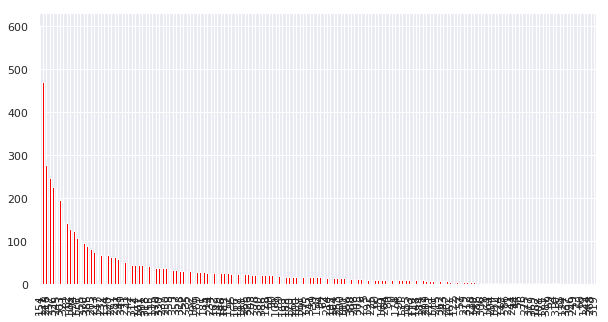

In [63]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='red')